In [1]:
from IPython.display import Code
import inspect

import sys
# Own code
sys.path.insert(0, './') # add local sources
from internal.GBP import GaussianState, VariableNode, FactorNode, FactorGraph


# TL;DR
This blog post is just me trying to reproduce the results of the excellent blog post: [A visual introduction to Gaussian Belief Propagation](https://gaussianbp.github.io/).
Please check this site out if you want to have a general introduction.
Additional resources about Belief Propagation in general can be found in the references \[2,3\].
The complete code can be found [here](https://github.com/Schwarzstift/blog/tree/gh-pages/src/GaussianBeliefPropagation/internal)

# Gaussian Belief Propagation - An Implementation guide
In here I want to focus on the implementational details of the basic algorithm.
Applications will be described in a second blog post.
This implementation does NOT focus on performance. 
Instead it focus on code readability so that it is easier to understand what's going on.
The main purpose I'm doing this, is to learn for myself. As reading stuff and actually replicating it, is something different.
To give credit where it belongs: I got some ideas on how to implement this from [this repository](https://github.com/joeaortiz/gbp) and from the original [source code](https://github.com/gaussianBP/gaussianBP.github.io/tree/2f724b9f59447ae58101c3c8d8f4b4ec32eb82a2/src) of the blog post.

Elaborates a bit more on the code. Nevertheless, you can find the complete implementation in my [repository](https://github.com/Schwarzstift/blog/tree/gh-pages/src/GaussianBeliefPropagation/internal).
If thats of interest to you, go ahead and read more :)

Without further ado, lets dive right into this.

## What is needed?

Before I start implementing stuff, I like to step back and look at the bigger picture.
What do we need for a basic GBP algorithm to work?

Gaussian Belief Propagation runs on a model called [Factor Graphs](https://en.wikipedia.org/wiki/Factor_graph) as such depited in the figure below, which basically defines our data structure.

In such a Factor Graph, factor nodes are depicted as rectangles.
Red factor nodes represent arbitraty factos, which have to be modeled according to your application.
The blue factor nodes represent the priors of the variable nodes, which are depicted as circles.
Not every variable node has to have a prior factor.
Two variable nodes can be connected via multiple factor nodes. 


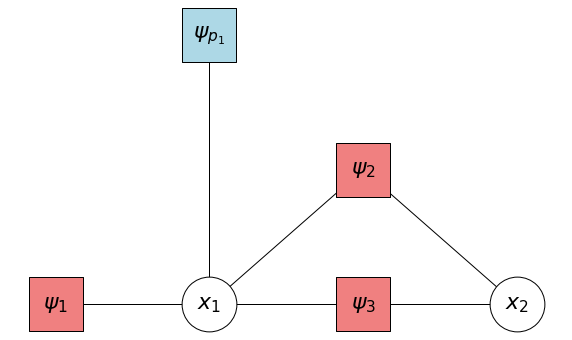

In [11]:
import pylab
import networkx as nx
import matplotlib


pylab.rcParams["figure.figsize"] = (10,6)
pylab.axes(frameon = 0)
G = nx.Graph([(0,1), (2,1), (1,3), (4,3), (5,1),(5,4)], with_labels=False)
pos = {0: (1, 0), 1: (2, 0), 2: (2, 1), 3: (3,0), 4:(4,0), 5:(3,0.5)}
optionsFactor = {
    "node_size": 3000,
    "node_color": "lightcoral",
    "edgecolors": "black",
    "linewidths": 1,
    "node_shape": 's',
}
optionsFactorPrior = {
    "node_size": 3000,
    "node_color": "lightblue",
    "edgecolors": "black",
    "linewidths": 1,
    "node_shape": 's',
}
optionsVariable = {
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    #"node_shape": 'o'
}
nx.draw_networkx_nodes(G, pos, nodelist=[1,4], **optionsVariable)
nx.draw_networkx_nodes(G, pos, nodelist=[0,3,5], **optionsFactor)
nx.draw_networkx_nodes(G, pos, nodelist=[2], **optionsFactorPrior)
# some math labels
labels = {}
labels[0] = r"$\psi_1$"
labels[1] = r"$x_1$"
labels[2] = r"$\psi_{p_1}$"
labels[3] = r"$\psi_3$"
labels[4] = r"$x_2$"
labels[5] = r"$\psi_2$"
nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="black")
# edges
#nx.draw_networkx_edges(G, pos, arrowstyle="->", arrows=True)
nx.draw_networkx_edges(G, pos, edge_color='k', arrowsize= 20, node_size=3000)
pylab.show()


Hence we need the following classes:
- a *gaussian state* class containing
    - mean and variance or eta and lambda in canonical form
- a *variable node* class containing
    - the current state belief of the node
    - a function to update the belief
    - a function to compute the message from a node to a factor
- a *factor node* class containing
    - the factor of the factor node
    - a function to compute the message from a factor to a node
- a *factor graph* class
    - which wraps everything up

Having this in mind, we can start implementing the base classes of a Gaussian Belief Propagation algorithm.

## Gaussian State

As the name Gaussian Belief Propagation implies is the bases of all the Gaussian distribution.
Hence we start with implementing a tiny helper class to keep the mean vector and covariance matrix close together.
As pointed out in this [blog post](https://gaussianbp.github.io/), the canonical form offers some computational advantages above the moments form.
Hence we will also use the state in this form.

In [3]:
lines = "class " + GaussianState.__name__ + "\n"
lines += inspect.getsource(GaussianState.__init__)
Code(lines, language="python")

class GaussianState
    def __init__(self, dimensionality: int):
        """
        Initialize a gaussian state
        :param dimensionality: number of dimensions of the state
        :param eta: canonical form of mean
        :param lam: canonical form of the covariance matrix
        """
        self.dim = dimensionality
        self.eta = np.zeros(self.dim)
        self.lam = np.zeros([self.dim, self.dim])

## Variable Node 

The variable node represent the random variables in your factor graph.
As we use Gaussian Belief Propagation (GBP), each variable is assumed to be normal distributed.

Keep in mind, that a variable node can represent a single random variable as well as a vector of random variables.
In this implementation, the number of random variables in refered to as the *dimension* of the VariableNode.


In [4]:
lines = "class " + VariableNode.__name__ + "\n"
lines += inspect.getsource(VariableNode.__init__)
Code(lines, language="python")

class VariableNode
    def __init__(self, dimensions: int):
        """
        Initialize the belief and prior with gaussian states
        :param dimensions: the dimensions of the gaussian state
        """
        self.idx = VariableNode.idx_counter
        VariableNode.idx_counter += 1
        self.belief = GaussianState(dimensions)
        self.prior = GaussianState(dimensions)
        self.dimensions = dimensions
        self.adj_factors_idx = []  # will be filled by Factors on creation
        self.factor_nodes = []  # will be filled at the end by the FactorGraph

        self.mu = np.zeros(dimensions)  # for debug/output purpose
        self.sigma = np.zeros([dimensions, dimensions])  # for debug/output purpose

The prior and belief of the Variable node are initialized with zero vectors and matrixes. Indicating an uninitialized variable with no prior.
One can define the prior afterwards, which is effectively the same as adding another factor node, which is only connected to this variable node and serves as it's prior.


### Belief update

Here I want to cite the Appendix B from [here](https://gaussianbp.github.io/):
> To compute the belief at a variable node, you take the product of incoming messages from all adjacent factors: 
> $$b_i(x_i)= \prod_{s \in N(i)} m_{f_s \rightarrow x_i}, $$
> where N(i) denotes the neighbours of nodes i. A Gaussian message has the canonical form: 
> $$ m = N^{-1}(x,\eta,\Lambda) \propto exp(-\frac{1}{2} x^\intercal \Lambda x+\eta^\intercal x), $$
> and so taking products of these messages is equivalent to summing the respective information vectors and precision matrices. The belief parameters $\eta_{b_i}$ and $\Lambda_{b_i}$ are therefore:
> $$ \eta_{b_i} = \sum_{s \in N(i)} \eta_{f_s \rightarrow x_i} \text{ and }  \Lambda_{b_i} = \sum_{s \in N(i)} \Lambda_{f_s \rightarrow x_i}$$
$$ N(i) = \text{set of adjacent nodes of i} $$

As the last two equations suggest, the belief update is simply a sum over the incoming messages.

So let's implement this:

In [5]:
lines = "class " + VariableNode.__name__ + "\n"
lines += "    ...\n\n"
lines += inspect.getsource(VariableNode.update_belief)
Code(lines, language="python")

class VariableNode
    ...

    def update_belief(self):
        """
        Updates the belief of a variable node & sends a message to all adjacent factors
        """
        eta = self.prior.eta.copy()
        lam = self.prior.lam.copy()
        for factor_idx in self.adj_factors_idx:
            factor = self.factor_nodes[factor_idx]
            eta_message, lam_message = factor.get_message_for(self.idx)
            eta += eta_message
            lam += lam_message

        # Ensure that matrix is positive-semi-definite
        lam = (lam + lam.T) / 2.
        lam -= np.identity(lam.shape[0]) * 1e-6

        self.belief.eta = eta
        self.belief.lam = lam
        if np.linalg.det(self.belief.lam) != 0:
            self.sigma = np.linalg.inv(self.belief.lam)  # Just for debugging/output
            self.mu = self.sigma @ self.belief.eta  # Just for debugging/output

        # Send message with updated belief to adjacent factors
        for factor_idx in self.adj_factors_idx:
            factor = self.factor_nodes[factor_idx]
            eta_message, lam_message = factor.get_message_for(self.idx)
            factor.receive_message_from(self.idx, eta - eta_message, lam - lam_message)

If the variable has not received any valid messages from a factor, the information matrix is 0. Hence one cannot compute the mean. 
Therefore we need to check if the information matrix is invertable by checking if it's determinat is not zero.

In the last section, the messages from this variable node to each factor_node is updated.

It is necessary to subtract the factor message from the overall estimate in order to fulfill the following equation:
$$ \eta_{x_i \rightarrow f_j} = \sum_{s \in N(i)\setminus j} \eta_{f_s \rightarrow x_i} \text{ and }  \Lambda_{x_i \rightarrow f_j} = \sum_{s \in N(i)\setminus j} \Lambda_{f_s \rightarrow x_i}$$


## Factor Node

The factor node models the dependencies between the variable nodes as a joint gaussian distribution of all adjacent variable nodes.

In this implementation, the factor nodes "registers" itself to it's adjacent variable nodes.


In [6]:
lines = "class " + FactorNode.__name__ + "\n"
lines += inspect.getsource(FactorNode.__init__)
Code(lines, language="python")

class FactorNode
    def __init__(self, adj_variable_nodes: List[VariableNode],
                 measurement_fn: Callable[[List[np.ndarray], Any], np.ndarray],
                 measurement_noise: np.ndarray,
                 measurement: Union[np.ndarray, float],
                 jacobian_fn: Callable[[List[np.ndarray], Any], np.ndarray],
                 args: Any):
        """
        Initialize internal variables & adds itself to all adjacent variable nodes
        :param adj_variable_nodes: all variable nodes, which are adjacent to this factor node
        :param measurement_fn: the measurement function
        :param measurement_noise: gaussian covariance matrix representing measurement noise
        :param measurement: the actual measurement
        :param jacobian_fn: the jacobian of the measurement function
        :param args: any additional args for the measurement/jacobian function
        """
        self.idx = FactorNode.idx_counter
        FactorNode.idx_counter += 1
        self.adj_variable_node_idxs = [v.idx for v in adj_variable_nodes]
        self.measurement_fn = measurement_fn
        self.measurement_noise = measurement_noise
        self.measurement = measurement
        self.jacobian_fn = jacobian_fn
        self.args = args
        self.adj_variable_messages = {}
        self.messages_to_adj_variables = {}
        self.linearization_point = []
        self.variable_nodes = []  # will be set by the FactorGraph at the end

        self.number_of_conditional_variables = 0
        for variable_node in adj_variable_nodes:
            variable_node.adj_factors_idx.append(self.idx)  # bind factor to variable
            self.number_of_conditional_variables += variable_node.dimensions
            self.adj_variable_messages[variable_node.idx] = deepcopy(variable_node.belief)
            self.messages_to_adj_variables[variable_node.idx] = GaussianState(variable_node.dimensions)
            self.linearization_point.append(np.zeros_like(variable_node.belief.eta))

        self.factor_eta = None
        self.factor_lam = None
        self.compute_factor()

### Compute factor

The factor of a factor node does not change over time, iff. the factor is linear.
As this is an implementation supporting none linear factors, it is necessary to recompute the factor each time the linearization point changes.

Usually, the mean is used as the linearization point X_0.

$$
\begin{align}
\eta &= J^T\Sigma^{-1}(d-(h(X_0) - JX_0)\\
\Lambda &= J^T\Sigma^{-1}J\\ \\
h(x) &= \text{measurement function}\\
J &= \text{Jaccobian of measurement function}\\
d &= \text{Measurement}\\
\Sigma &= \text{Measurement Noise}\\
\end{align}
$$


In [7]:
lines = "class " + FactorNode.__name__ + "\n"
lines += "    ...\n\n"
lines += inspect.getsource(FactorNode.compute_factor)
Code(lines, language="python")

class FactorNode
    ...

    def compute_factor(self):
        """
        Computes the factor of the factor node.
        Should be called, when the linearization point changes.
        """
        jacobian = self.jacobian_fn(self.linearization_point, *self.args)

        predicted_measurement = self.measurement_fn(self.linearization_point, *self.args)

        inverse_measurement_noise = np.linalg.inv(self.measurement_noise)
        self.factor_eta = jacobian.T @ inverse_measurement_noise * (
                self.measurement - (predicted_measurement - (jacobian @ np.array(self.linearization_point).flatten())))
        self.factor_eta = self.factor_eta.flatten()

        self.factor_lam = jacobian.T @ inverse_measurement_noise @ jacobian

        # Ensure that matrix is positive-semi-definite
        self.factor_lam = (self.factor_lam + self.factor_lam.T) / 2.
        self.factor_lam += np.identity(self.factor_lam.shape[0]) * 1e-6

Still the factor is a gaussian distribution with eta and lam as its parameters.

### Compute factor to variable messages

Here I want to cite the blog post again. This time Appendix B: Factor to variable message passing:

> To send a message from a factor node to a variable node, the factor aggregates messages from all other adjacent variable nodes before marginalising out all other adjacent variable nodes: 
> $$m_{f_j\rightarrow x_i} = \sum_{X_j \setminus x_i} f_j(X_j) \prod_{k \in N(j)\setminus i} m_{x_k \rightarrow f_j}$$
> To see how this computation is implemented for Gaussian models with the canonical form, consider a factor $f$ connected to 3 variable nodes\[$x_1,x_2,x_3$\] where we are computing the message to variable $x_1$ The factor $f([x_1,x_2,x_3]) = N^{-1}([x_1,x_2,x_3]; \eta_f, \Lambda_f)$ is a Gaussian over the variables and can be divided up as follows:
>$$
\eta_f = \begin{bmatrix} \eta_{f_1} \\ \eta_{f_2} \\ \eta_{f_3} \end{bmatrix} \text{and} \Lambda_f = \begin{bmatrix}  
\Lambda_{f_{11}} & \Lambda_{f_{12}}& \Lambda_{f_{13}}\\
\Lambda_{f_{21}} & \Lambda_{f_{22}}& \Lambda_{f_{23}}\\
\Lambda_{f_{31}} & \Lambda_{f_{32}}& \Lambda_{f_{33}}\end{bmatrix}
$$
> The first part of the computation for the message to $x_1$, is to take the product of the factor distribution and messages coming from the other adjacent variables nodes ($x_2$ and $x_3$). This yields a Gaussian with the following parameters:
>$$
\eta_f = \begin{bmatrix} \eta_{f_1} \\ \eta_{f_2}+\eta_{x_2 \rightarrow f} \\ \eta_{f_3}+\eta_{x_3 \rightarrow f} \end{bmatrix} \text{and} \Lambda_f = \begin{bmatrix}  
\Lambda_{f_{11}} & \Lambda_{f_{12}}& \Lambda_{f_{13}}\\
\Lambda_{f_{21}} & \Lambda_{f_{22}}+ \Lambda_{x_2 \rightarrow f} & \Lambda_{f_{23}}\\
\Lambda_{f_{31}} & \Lambda_{f_{32}}& \Lambda_{f_{33}}+ \Lambda_{x_3 \rightarrow f}
\end{bmatrix}
$$
> To complete message passing from this factor, we must marginalise out all variables apart from the variable $x_1$ which is the recipient of the message. The formula for marginalising a Gaussian in the canonical form is given in Eustice et al. For the joint Gaussian distribution over variables a and b parameterized by: 
>$$
\eta = \begin{bmatrix} \eta_a \\ eta_b \end{bmatrix} \text{and} \Lambda = \begin{bmatrix} \Lambda_{aa} & \Lambda_{ab}\\ \Lambda_{ba} & \Lambda_{bb}\end{bmatrix}
$$
> the marginal distribution over a after marginalising out b has parameters:
> $$
\eta_{Ma} = \eta_a - \Lambda_{ab} \Lambda_{bb}^{-1} \eta_b \text{ and } \Lambda_{Ma} = \Lambda_{ab}\Lambda_{bb}^{-1}\Lambda_{ba}
$$
> To apply these formula to the partitioned joint Gaussian parameterized by $\eta^\prime_{f}$ and $\Lambda^\prime_{f}$, we first reorder the vector and matrix to bring the output variable to the top (in our example the recipient variable $x_1$ is already at the top, so we do not need to reorder). Then we identify the subblocks $a = x_1$ and $b = [x_2, x_3]$ and apply the above marginalization equations to form the parameters of the outgoing message.

As pointed out, there are two-three steps to compute:
1. Product of the incoming messages
2. Reordering
3. Marginalization

I recommend the reader to take some time to compare the formulars with the apropiate code segments to see where what is computed.

In [8]:
lines = "class " + FactorNode.__name__ + "\n"
lines += "    ...\n\n"
lines += inspect.getsource(FactorNode.compute_outgoing_messages)
Code(lines, language="python")

class FactorNode
    ...

    def compute_outgoing_messages(self):
        """
        Computes all factor to variable messages for adjacent variable nodes.
        The results are stored in a class variable

        See this blog post Appendix B for the equations: https://gaussianbp.github.io/
        """
        current_variable_position = 0
        for variable_node_idx in self.adj_variable_node_idxs:
            variable_node = self.variable_nodes[variable_node_idx]
            eta_factor, lam_factor = self.factor_eta.copy(), self.factor_lam.copy()

            # For every node take the product of factor and incoming messages
            current_factor_position = 0
            for other_variable_idx in self.adj_variable_node_idxs:
                other_variables = self.variable_nodes[other_variable_idx]
                if variable_node_idx != other_variable_idx:
                    start = current_factor_position
                    end = current_factor_position + other_variables.dimensions
                    eta_factor[start:end] += self.adj_variable_messages[other_variables.idx].eta
                    lam_factor[start:end, start:end] += self.adj_variable_messages[other_variables.idx].lam
                current_factor_position += other_variables.dimensions

            # Marginalization to variable node
            # - First "reorder" variable_nodes's (short a) elements to the top
            cur_dims = variable_node.dimensions
            start = current_variable_position
            end = current_variable_position + cur_dims
            eta_a = eta_factor[start:end]  # information vector of variable_node
            eta_b = np.concatenate((eta_factor[:start], eta_factor[end:]))  # information vector of the rest

            lam_aa = lam_factor[start:end, start:end]
            lam_ab = np.hstack((lam_factor[start:end, :start], lam_factor[start:end, end:]))
            lam_ba = np.vstack((lam_factor[:start, start:end], lam_factor[end:, start:end]))
            lam_bb = np.block([[lam_factor[:start, :start], lam_factor[:start, end:]],
                               [lam_factor[end:, :start], lam_factor[end:, end:]]])

            # - Then marginalize according to https://ieeexplore.ieee.org/document/4020357
            new_message_eta = eta_a - lam_ab @ np.linalg.inv(lam_bb) @ eta_b
            new_message_lam = lam_aa - lam_ab @ np.linalg.inv(lam_bb) @ lam_ba

            # Ensure that matrix is positive-semi-definite
            new_message_lam = (new_message_lam + new_message_lam.T) / 2.
            new_message_lam += np.identity(new_message_lam.shape[0]) * 1e-6

            self.messages_to_adj_variables[variable_node_idx].eta = new_message_eta
            self.messages_to_adj_variables[variable_node_idx].lam = new_message_lam

            current_variable_position += variable_node.dimensions

## Factor Graph

The factor graph has not much logic inside it. It just calls the functions of the appropriate nodes.

At the beginning, it will give all nodes a complete list of all factors/variable nodes, which they need to send their messages.

In [9]:
lines = "class " + FactorGraph.__name__ + "\n"
lines += "    ...\n\n"
lines += inspect.getsource(FactorGraph.__init__)
Code(lines, language="python")

class FactorGraph
    ...

    def __init__(self, variable_nodes: List[VariableNode], factor_nodes: List[FactorNode]):
        self.variable_nodes = variable_nodes
        self.factor_nodes = factor_nodes
        for v in self.variable_nodes:
            v.factor_nodes = self.factor_nodes
        for f in self.factor_nodes:
            f.variable_nodes = self.variable_nodes

### Synchronous Iteration

Currently, I only implemented the synchronous iteration, but others are possible.
To be sure, I also relinearize the factors before each iteration.

In [10]:
lines = "class " + FactorGraph.__name__ + "\n"
lines += "    ...\n\n"
lines += inspect.getsource(FactorGraph.synchronous_iteration)
Code(lines, language="python")

class FactorGraph
    ...

    def synchronous_iteration(self):
        """
        Triggers a single synchronous iteration over all nodes (factor and variable nodes)
        """
        self.relinearize_factors()
        self.compute_all_messages()
        self.update_all_beliefs()

# Usage example

To see the Gaussian Belief Propagation in action, I would recommend you to read my next blog article about Contour Fitting.

# References

1. Ortiz, J.; Evans, T. & Davison, A. J. A visual introduction to Gaussian Belief Propagation CoRR, 2021, abs/2107.02308 [link](https://gaussianbp.github.io/)
2. Bishop, C. M. Pattern Recognition and Machine Learning (Information Science and Statistics) Springer-Verlag, 2006 [pdf](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)
3. Barber, D. Bayesian Reasoning and Machine Learning Cambridge University Press, 2012 [pdf](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/090310.pdf)
